### Tensorflow study with CIFAR10

There are lots of tutorials for Tensorflow with MNIST, but they didn't tell the details of tensorflow. So I decided to write this with my study. 

At first, we need data. The 1.0 version input I use the way of cs321n. 

In [1]:
import tensorflow as tf
import numpy as np
from data_utils import get_CIFAR10_data
import time
from datetime import datetime
import os.path


start_time = time.time()
data = get_CIFAR10_data(50000, 0, 10000)
end_time = time.time()
print(end_time - start_time)

2.48349285126


Ok. Let us build our first model with softmax. Of course you can try other models such as SVM. 

In [2]:
beginTime = time.time()
x = tf.placeholder(tf.float32, [None, 3072])
W = tf.Variable(tf.zeros([3072, 10]))
b = tf.Variable(tf.zeros([10]))
# Building our model
logits = tf.nn.softmax(tf.matmul(x, W) + b)
y = tf.placeholder(tf.int64, [None])

# Computing the loss of this model
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y))
# Optimazation
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(loss)


correct_prediction = tf.equal(tf.argmax(logits, 1), y)

# The percentage of right prediction
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(1000):
    # Each epoch we choose 100 sample data randomly to train
    indices = np.random.choice(data['X_train'].shape[0], 100)
    batch_xs = data['X_train'][indices].reshape(100, 3072)
    batch_ys = data['y_train'][indices].astype(int)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys})
        print('Step {:5d}: training accuracy {:g}'.format(i, train_accuracy))
        
    sess.run(train_step, feed_dict={x: batch_xs,y: batch_ys})
    
test_accuracy = sess.run(accuracy, feed_dict={x: data['X_test'].reshape(10000, 3072),y: data['y_test']})
print('Test accuracy {:g}'.format(test_accuracy))
    
endTime = time.time()
print('Total time: {:5.2f}s'.format(endTime - beginTime))

Step     0: training accuracy 0.45
Step   100: training accuracy 0.27
Step   200: training accuracy 0.24
Step   300: training accuracy 0.36
Step   400: training accuracy 0.29
Step   500: training accuracy 0.25
Step   600: training accuracy 0.27
Step   700: training accuracy 0.32
Step   800: training accuracy 0.29
Step   900: training accuracy 0.23
Test accuracy 0.2695
Total time:  6.69s


In [2]:
def inference(images, image_pixels, hidden_units, classes, reg_constant=0):
    
    # Define the layer1
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable(
            name = 'weights',
            shape = [image_pixels, hidden_units],
            initializer = tf.truncated_normal_initializer(stddev = 1.0/np.sqrt(float(image_pixels))),
            regularizer = tf.contrib.layers.l2_regularizer(reg_constant)
        )
        
        biases = tf.Variable(tf.zeros([hidden_units]), name = 'biases')
        
        # Define the layer's output
        hidden = tf.nn.relu(tf.matmul(images, weights) + biases)
        
    # Define the layer2
    with tf.variable_scope('Layer2'):
        weights = tf.get_variable(
            name = 'weights',
            shape = [hidden_units, classes],
            initializer = tf.truncated_normal_initializer(stddev = 1.0/np.sqrt(float(hidden_units))),
            regularizer = tf.contrib.layers.l2_regularizer(reg_constant)
        )
        
        biases = tf.Variable(tf.zeros([classes]), name = 'biases')
        
        # Define the layer's output
        logits = tf.matmul(hidden, weights) + biases
        
        # Define summery-operation for 'logits'-variable
        tf.summary.histogram('logits', logits)
        
    return logits

def loss(logits, labels):
    with tf.variable_scope('Loss'):
        cross_entropy = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=labels, name='cross_entropy'))
        # Operation for the loss function
        loss = cross_entropy + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        # Add a scalar summary for the loss
        tf.summary.scalar('loss', loss)
        
    return loss
    
def training(loss, learning_rate):
    # Create a variable to track the global step
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    # Create a gradient descent optimizer
    # (which also increments the global step counter)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss, global_step=global_step)
    return train_step

def evaluation(logits, labels):
    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        tf.summary.scalar('train_accuracy', accuracy)
    return accuracy

The result is so bad. Don't worry, we will optimize the model at next steps.

What the performs of a two-layer neural work? Let us try. 

In [3]:
beginTime = time.time()

images = tf.placeholder(tf.float32, [None, 3072])
labels = tf.placeholder(tf.int64, [None])

logits = inference(images, 3072, 120, 10, 0.1)
loss = loss(logits, labels)
train_step = training(loss, 0.001)
accuracy = evaluation(logits, labels)
summary = tf.summary.merge_all()
saver = tf.train.Saver()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
logdir = 'tf_logs/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
summary_writer = tf.summary.FileWriter(logdir, sess.graph)

for i in range(2000):
    indices = np.random.choice(data['X_train'].shape[0], 200)
    batch_xs = data['X_train'][indices].reshape(200, 3072)
    batch_ys = data['y_train'][indices]
    feed_dict = {
        images: batch_xs,
        labels: batch_ys
    }
    
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict=feed_dict)
        print('Step {:d}, training accuracy {:g}'.format(i, train_accuracy))
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, i)
        
    # Perform a single training step
    sess.run([train_step, loss], feed_dict=feed_dict)

    # Periodically save checkpoint
    if (i + 1) % 1000 == 0:
      checkpoint_file = os.path.join('tf_logs', 'checkpoint')
      saver.save(sess, checkpoint_file, global_step=i)
      print('Saved checkpoint')
    
test_accuracy = sess.run(accuracy, feed_dict={images: data['X_test'].reshape(10000, 3072), labels: data['y_test']})
print('Test accuracy {:g}'.format(test_accuracy))

endTime = time.time()
print('Total time: {:5.2f}s'.format(endTime - beginTime))

Step 0, training accuracy 0.12
Step 100, training accuracy 0.345
Step 200, training accuracy 0.445
Step 300, training accuracy 0.38
Step 400, training accuracy 0.385
Step 500, training accuracy 0.38
Step 600, training accuracy 0.505
Step 700, training accuracy 0.39
Step 800, training accuracy 0.44
Step 900, training accuracy 0.485
Saved checkpoint
Step 1000, training accuracy 0.425
Step 1100, training accuracy 0.505
Step 1200, training accuracy 0.55
Step 1300, training accuracy 0.435
Step 1400, training accuracy 0.48
Step 1500, training accuracy 0.485
Step 1600, training accuracy 0.57
Step 1700, training accuracy 0.555
Step 1800, training accuracy 0.485
Step 1900, training accuracy 0.545
Saved checkpoint
Test accuracy 0.4517
Total time: 27.21s


Let us go into the details of this strategy. The steps are inference, loss, training and evalution. At inference, we define a two-layer neural network. To build the graph of this model, we build drawing node at each layer with variable_scope(). To spare the space of computer, we use [shareing variables](https://www.tensorflow.org/programmers_guide/variable_scope) with tf.get_variable(). We build two layers. At loss, we remove the REGULARIZATION_LOSSES because the result is so bad. At training we use GradientDescentOptimizer to minimize the loss. 
To visualize the whole model, we use the tensorboard of tensorflow. With variable_scope to build graph node, just like this:
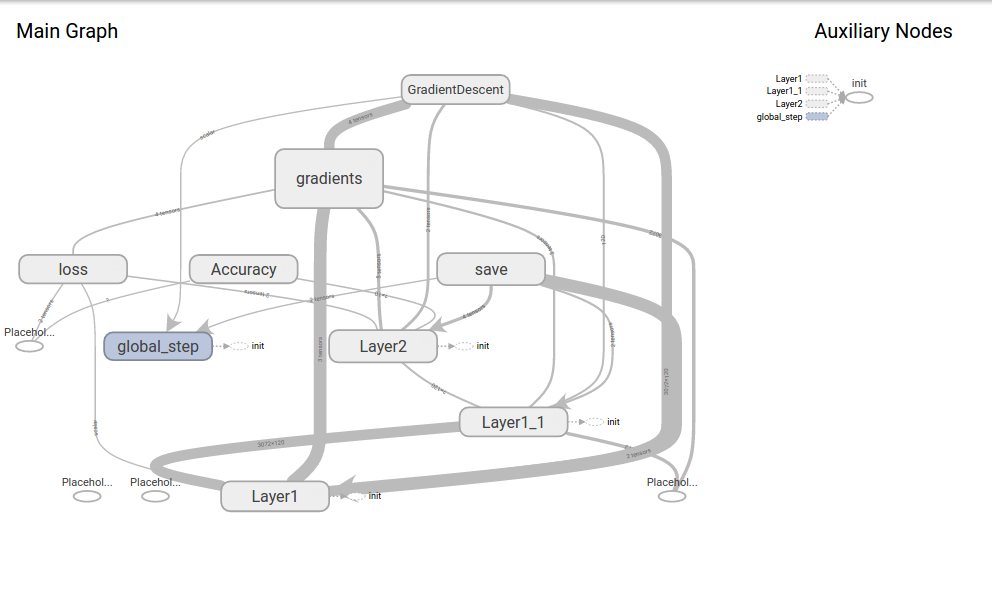
We also use tf.summary.scalar() to build the graph of trend of accuracy and loss:
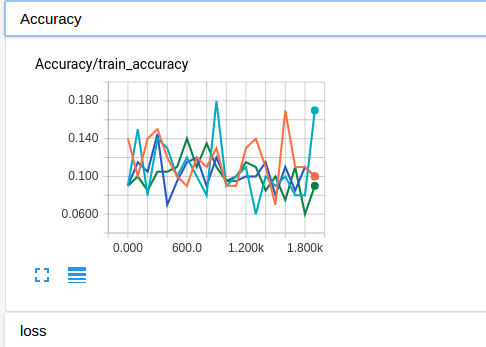

We still choose batch randomly which means there is some data cannot be chose. We define a function gen_batch() to build data batch which can cover all data. To use memory effectively, we use yield not return in this function, because the yield builds a generator to keep the result which will be constant space consume not to be a list as return. Due to the variable data is a dict, which is difficult to generate batches, we use [zip](https://docs.python.org/2/library/functions.html) to map X_train and y_train into one list. When using the batch data, unzip the data to two variables with zip(*).

In [3]:
def gen_batch(data, batch_size, num_iter):
  data = np.array(data)
  index = len(data)
  for i in range(num_iter):
    index += batch_size
    if (index + batch_size > len(data)):
      index = 0
      shuffled_indices = np.random.permutation(np.arange(len(data)))
      data = data[shuffled_indices]
    yield data[index:index + batch_size]

beginTime = time.time()

images = tf.placeholder(tf.float32, [None, 3072])
labels = tf.placeholder(tf.int64, [None], name = 'image-labels')

logits = inference(images, 3072, 120, 10, 0.1)
loss = loss(logits, labels)
train_step = training(loss, 0.001)
accuracy = evaluation(logits, labels)
summary = tf.summary.merge_all()
saver = tf.train.Saver()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
logdir = 'tf_logs/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
summary_writer = tf.summary.FileWriter(logdir, sess.graph)

# Too keep the input 2-dimension
data['X_train'] = data['X_train'].reshape(data['X_train'].shape[0], 3072)
data['X_test'] = data['X_test'].reshape(data['X_test'].shape[0], 3072)
# Map X_train and y_train into one list
zipped_data = zip(data['X_train'], data['y_train'])
batches = gen_batch(zipped_data, 400, 2000)

for i in range(2000):
    batch = next(batches)
    # unzip the data
    images_batch, labels_batch = zip(*batch)
    feed_dict = {
        images: images_batch,
        labels: labels_batch
    }
    
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict=feed_dict)
        print('Step {:d}, training accuracy {:g}'.format(i, train_accuracy))
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, i)
        
    # Perform a single training step
    sess.run([train_step, loss], feed_dict=feed_dict)

    # Periodically save checkpoint
    if (i + 1) % 1000 == 0:
      checkpoint_file = os.path.join('tf_logs', 'checkpoint')
      saver.save(sess, checkpoint_file, global_step=i)
      print('Saved checkpoint')
    
test_accuracy = sess.run(accuracy, feed_dict={images: data['X_test'].reshape(10000, 3072), labels: data['y_test']})
print('Test accuracy {:g}'.format(test_accuracy))

endTime = time.time()
print('Total time: {:5.2f}s'.format(endTime - beginTime))

Step 0, training accuracy 0.115
Step 100, training accuracy 0.3525
Step 200, training accuracy 0.3125
Step 300, training accuracy 0.39
Step 400, training accuracy 0.4625
Step 500, training accuracy 0.4475
Step 600, training accuracy 0.5075
Step 700, training accuracy 0.4075
Step 800, training accuracy 0.4625
Step 900, training accuracy 0.4475
Saved checkpoint
Step 1000, training accuracy 0.47
Step 1100, training accuracy 0.5025
Step 1200, training accuracy 0.5025
Step 1300, training accuracy 0.535
Step 1400, training accuracy 0.5175
Step 1500, training accuracy 0.54
Step 1600, training accuracy 0.4825
Step 1700, training accuracy 0.4925
Step 1800, training accuracy 0.5475
Step 1900, training accuracy 0.5375
Saved checkpoint
Test accuracy 0.4623
Total time: 44.15s


Let us check the tensorboard:
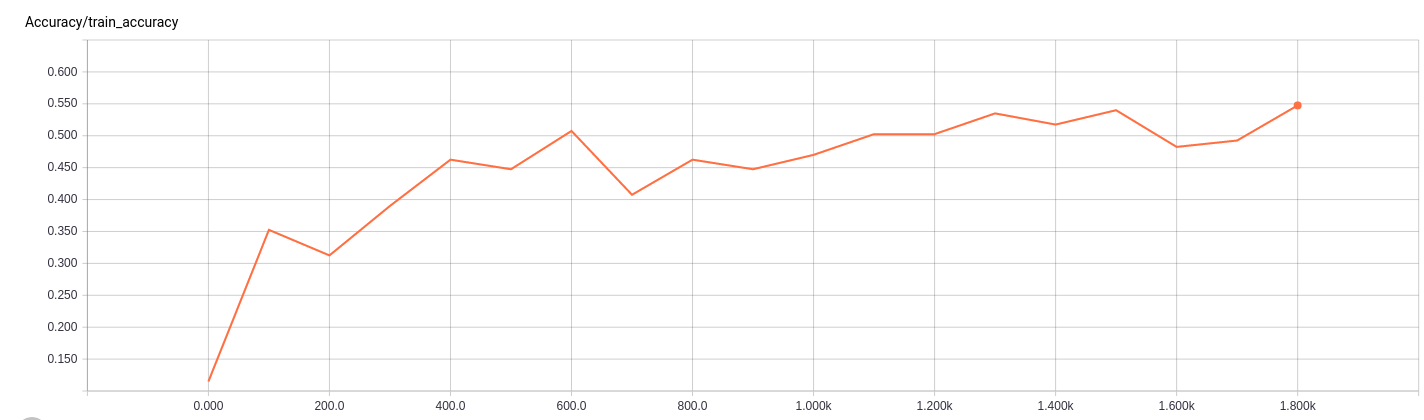
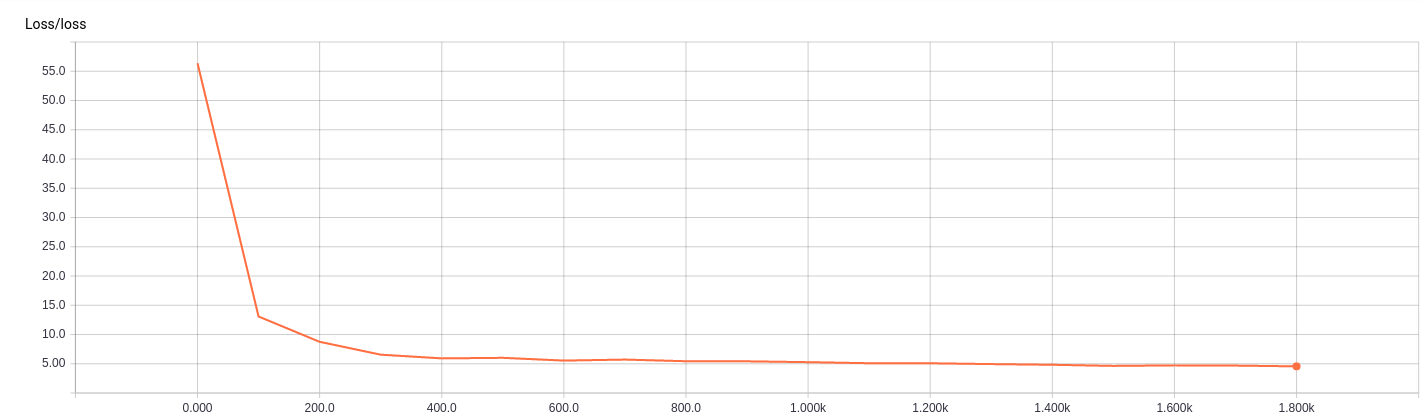
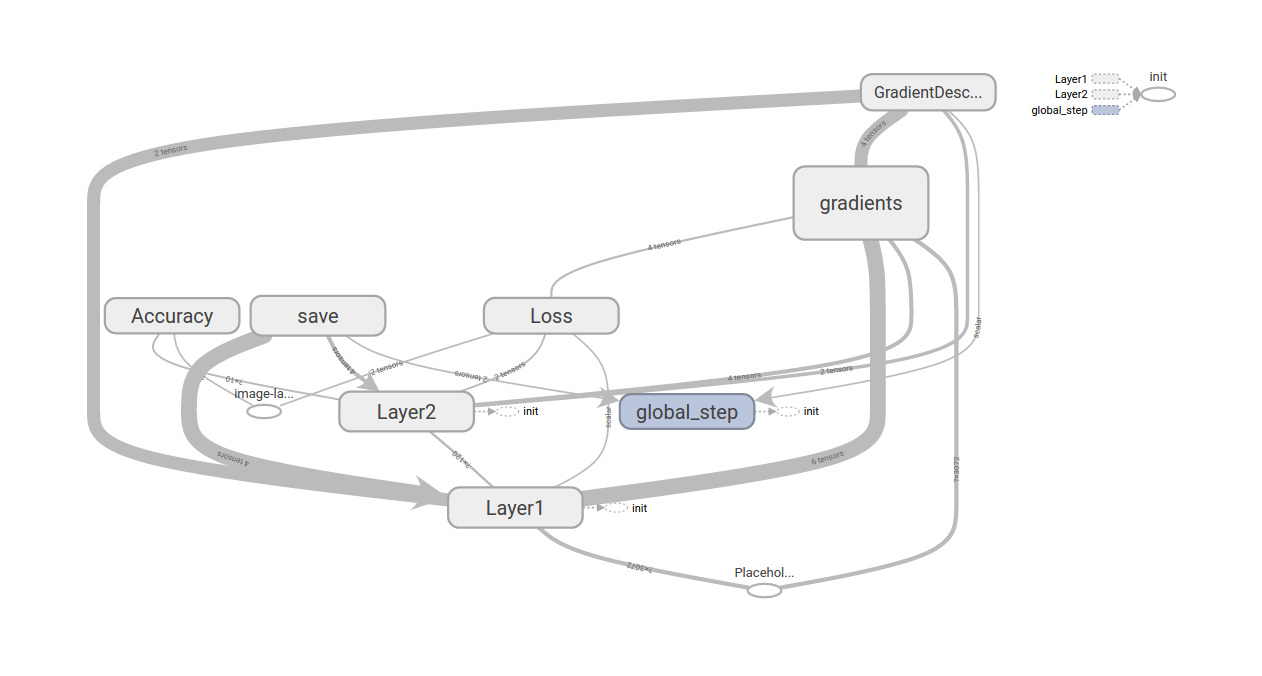
It is clear to see the whole process. 


There are lots of parameters we should choose. We can use [tf.flags](https://www.tensorflow.org/api_docs/python/tf/flags) to help us to finish this work. 

In [ ]:
flags = tf.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.001, 'Learning rate for the training.')
flags.DEFINE_integer('max_steps', 2000, 'Number of steps to run trainer.')
flags.DEFINE_integer('hidden1', 120, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('batch_size', 400,
  'Batch size. Must divide dataset sizes without remainder.')
flags.DEFINE_string('train_dir', 'tf_logs',
  'Directory to put the training data.')
flags.DEFINE_float('reg_constant', 0.1, 'Regularization constant.')


def gen_batch(data, batch_size, num_iter):
  data = np.array(data)
  index = len(data)
  for i in range(num_iter):
    index += batch_size
    if (index + batch_size > len(data)):
      index = 0
      shuffled_indices = np.random.permutation(np.arange(len(data)))
      data = data[shuffled_indices]
    yield data[index:index + batch_size]

beginTime = time.time()

images = tf.placeholder(tf.float32, [None, 3072])
labels = tf.placeholder(tf.int64, [None], name = 'image-labels')

logits = inference(images, 3072, FLAGS.hidden1, 10, FLAGS.reg_constant)
loss = loss(logits, labels)
train_step = training(loss, FLAGS.learning_rate)
accuracy = evaluation(logits, labels)
summary = tf.summary.merge_all()
saver = tf.train.Saver()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
logdir = FLAGS.train_dir + '/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
summary_writer = tf.summary.FileWriter(logdir, sess.graph)

# Too keep the input 2-dimension
data['X_train'] = data['X_train'].reshape(data['X_train'].shape[0], 3072)
data['X_test'] = data['X_test'].reshape(data['X_test'].shape[0], 3072)
# Map X_train and y_train into one list
zipped_data = zip(data['X_train'], data['y_train'])
batches = gen_batch(zipped_data, FLAGS.batch_size, FLAGS.max_steps)

for i in range(FLAGS.max_steps):
    batch = next(batches)
    # unzip the data
    images_batch, labels_batch = zip(*batch)
    feed_dict = {
        images: images_batch,
        labels: labels_batch
    }
    
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict=feed_dict)
        print('Step {:d}, training accuracy {:g}'.format(i, train_accuracy))
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, i)
        
    # Perform a single training step
    sess.run([train_step, loss], feed_dict=feed_dict)

    # Periodically save checkpoint
    if (i + 1) % 1000 == 0:
      checkpoint_file = os.path.join('tf_logs', 'checkpoint')
      saver.save(sess, checkpoint_file, global_step=i)
      print('Saved checkpoint')
    
test_accuracy = sess.run(accuracy, feed_dict={images: data['X_test'].reshape(10000, 3072), labels: data['y_test']})
print('Test accuracy {:g}'.format(test_accuracy))

endTime = time.time()
print('Total time: {:5.2f}s'.format(endTime - beginTime))

Finally, Let us try simple CNN. 

In [1]:
import tensorflow as tf
import numpy as np
from data_utils import get_CIFAR10_data
import time
from datetime import datetime
import os.path


start_time = time.time()
data = get_CIFAR10_data(50000, 0, 10000)
end_time = time.time()
print(end_time - start_time)

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_integer('batch_size', 400, 'Number of images to process in a batch.')
tf.app.flags.DEFINE_integer('image_height', 32, 'image_height')
tf.app.flags.DEFINE_integer('image_width', 32, 'image_width')
tf.app.flags.DEFINE_integer('image_depth', 3, 'image_depth')
tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning_rate')
tf.app.flags.DEFINE_integer('max_steps', 2000, 'max_steps')
tf.app.flags.DEFINE_string('train_dir', 'tf_logs',
  'Directory to put the training data.')


def inference(images):
    print(images.shape)
    # conv1
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable(
            name='weights',
            shape=[5, 5, 3, 64],
            initializer=tf.truncated_normal_initializer(stddev=5e-2)
        )

        conv = tf.nn.conv2d(images, weights, [1, 1, 1, 1], padding='SAME')

        biases = tf.get_variable(name='biases', shape=[64], initializer=tf.constant_initializer(0.0))

        pre_activation = tf.nn.bias_add(conv, biases)

        conv1 = tf.nn.relu(pre_activation, name=scope.name)

        tf.summary.scalar(conv1.op.name + '/sparsity',
                          tf.nn.zero_fraction(conv1))

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='SAME', name='pool1')

    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        weights = tf.get_variable(
            name='weights',
            shape=[5, 5, 64, 64],
            initializer=tf.truncated_normal_initializer(stddev=5e-2)
        )

        conv = tf.nn.conv2d(norm1, weights, [1, 1, 1, 1], padding='SAME')

        biases = tf.get_variable(name='biases', shape=[64], initializer=tf.constant_initializer(0.1))

        pre_activation = tf.nn.bias_add(conv, biases)

        conv2 = tf.nn.relu(pre_activation, name=scope.name)

        tf.summary.scalar(conv2.op.name + '/sparsity',
                          tf.nn.zero_fraction(conv2))

    # norm2
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm2')
    # pool2
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                           strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    # local3
    with tf.variable_scope('local3') as scope:
        reshape = tf.reshape(pool2, [FLAGS.batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable(
            name='weights',
            shape=[dim, 384],
            initializer=tf.truncated_normal_initializer(stddev=0.04)
        )

        biases = tf.get_variable(name='biases', shape=[384], initializer=tf.constant_initializer(0.1))

        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

        tf.summary.scalar(local3.op.name + '/sparsity',
                          tf.nn.zero_fraction(local3))

    # local4
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable(
            name='weights',
            shape=[384, 192],
            initializer=tf.truncated_normal_initializer(stddev=0.04)
        )

        biases = tf.get_variable(name='biases', shape=[192], initializer=tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
        tf.summary.scalar(local4.op.name + '/sparsity',
                          tf.nn.zero_fraction(local4))

    # linear layer(WX + b),
    # We don't apply softmax here because
    # tf.nn.sparse_softmax_cross_entropy_with_logits accepts the unscaled logits
    # and performs the softmax internally for efficiency.
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.get_variable(
            name='weights',
            shape=[192, 10],
            initializer=tf.truncated_normal_initializer(stddev=1/192.0)
        )
        biases = tf.get_variable(name='biases', shape=[10], initializer=tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
        tf.summary.scalar(softmax_linear.op.name + '/sparsity',
                          tf.nn.zero_fraction(softmax_linear))

    return softmax_linear


def loss(logits, labels):
    with tf.variable_scope('Loss'):
        cross_entropy = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=labels, name='cross_entropy'))
        # Operation for the loss function
        loss = cross_entropy# + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

        # Add a scalar summary for the loss
        tf.summary.scalar('loss', loss)

    return loss


def training(loss, learning_rate):
    # Create a variable to track the global step
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Create a gradient descent optimizer
    # (which also increments the global step counter)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss, global_step=global_step)
    return train_step


def evaluation(logits, labels):
    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        tf.summary.scalar('train_accuracy', accuracy)
    return accuracy


def gen_batch(data, batch_size, num_iter):
  data = np.array(data)
  index = len(data)
  for i in range(num_iter):
    index += batch_size
    if (index + batch_size > len(data)):
      index = 0
      shuffled_indices = np.random.permutation(np.arange(len(data)))
      data = data[shuffled_indices]
    yield data[index:index + batch_size]

beginTime = time.time()

images = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.image_height, FLAGS.image_width, FLAGS.image_depth])
labels = tf.placeholder(tf.int64, shape=[FLAGS.batch_size])

logits = inference(images)
loss = loss(logits, labels)
train_step = training(loss, FLAGS.learning_rate)
accuracy = evaluation(logits, labels)
summary = tf.summary.merge_all()
saver = tf.train.Saver()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
logdir = FLAGS.train_dir + '/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
summary_writer = tf.summary.FileWriter(logdir, sess.graph)

data['X_train'] = data['X_train'].transpose(0, 2, 3, 1)
data['X_test'] = data['X_test'].transpose(0, 2, 3, 1)
zipped_data = zip(data['X_train'], data['y_train'])
batches = gen_batch(zipped_data, FLAGS.batch_size, FLAGS.max_steps)

for i in range(FLAGS.max_steps):
    batch = next(batches)
    # unzip the data
    images_batch, labels_batch = zip(*batch)
    feed_dict = {
        images: images_batch,
        labels: labels_batch
    }

    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict=feed_dict)
        print('Step {:d}, training accuracy {:g}'.format(i, train_accuracy))
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, i)

    # Perform a single training step
    sess.run([train_step, loss], feed_dict=feed_dict)

    # Periodically save checkpoint
    if (i + 1) % 1000 == 0:
        checkpoint_file = os.path.join('tf_logs', 'checkpoint')
        saver.save(sess, checkpoint_file, global_step=i)
        print('Saved checkpoint')

test_accuracy = sess.run(accuracy, feed_dict={images: data['X_test'], labels: data['y_test']})
print('Test accuracy {:g}'.format(test_accuracy))

endTime = time.time()
print('Total time: {:5.2f}s'.format(endTime - beginTime))

5.23939394951
(400, 32, 32, 3)
Step 0, training accuracy 0.1125
Step 100, training accuracy 0.39
Step 200, training accuracy 0.4575
Step 300, training accuracy 0.4575
Step 400, training accuracy 0.48
Step 500, training accuracy 0.5425
Step 600, training accuracy 0.55
Step 700, training accuracy 0.5775
Step 800, training accuracy 0.595
Step 900, training accuracy 0.63
Saved checkpoint
Step 1000, training accuracy 0.6175
Step 1100, training accuracy 0.665
Step 1200, training accuracy 0.635
Step 1300, training accuracy 0.715
Step 1400, training accuracy 0.665
Step 1500, training accuracy 0.7175
Step 1600, training accuracy 0.6825
Step 1700, training accuracy 0.655
Step 1800, training accuracy 0.735
Step 1900, training accuracy 0.7325
Saved checkpoint


ValueError: Cannot feed value of shape (10000, 32, 32, 3) for Tensor u'Placeholder:0', which has shape '(400, 32, 32, 3)'